---
# Acknowledgement

Portions of this notebook were generated with the assistance of generative AI and have been reviewed and modified by the authors.

---

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from dotenv import find_dotenv
%load_ext dotenv
%dotenv   

# Set cwd to project root to allow access to file paths via os.getenv()
project_root = Path(find_dotenv()).resolve().parent
os.chdir(project_root)   

In [2]:
# Load the full training level feature set
df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")

# Split off 30% for validation, stratified on HIGH_SEVERITY
train_df, val_df = train_test_split(
    df, test_size=0.3, stratify=df["HIGH_SEVERITY"], random_state=42
)

# Prep function to extract X/y and clean
def prep(df):
    X = (
        df.select_dtypes(include=[np.number])
        .drop(columns=["ACCIDENT_NO", "HIGH_SEVERITY"], errors="ignore")
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    ) 
    y = df["HIGH_SEVERITY"]
    return X, y


# Create train-validation splits
X_train, y_train = prep(train_df)
X_val, y_val = prep(val_df)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_depth': 7, 'min_samples_leaf': 10}
Best cross-val F1: 0.5314797616524326

Decision Tree (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.60      0.65     28735
           1       0.48      0.61      0.54     17497

    accuracy                           0.60     46232
   macro avg       0.60      0.60      0.59     46232
weighted avg       0.62      0.60      0.61     46232



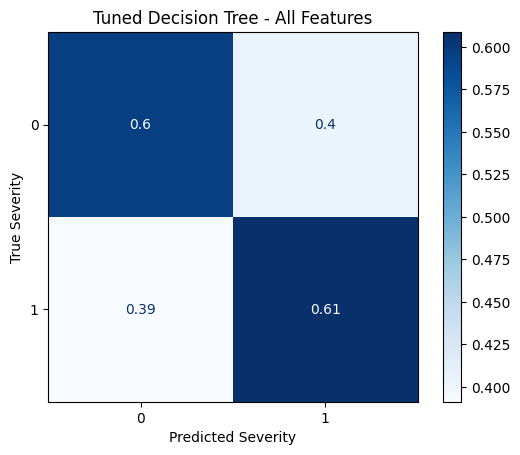

In [3]:
# Define the parameter grid
param_grid = {"max_depth": [3, 5, 7], "min_samples_leaf": [1, 5, 10]}

# Set up a stratified k-fold splitter with k=5
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Wrap the decision tree in GridSearchCV
grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight="balanced"),
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

# Fit on training data
grid.fit(X_train, y_train)

# Inspect best params and best score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# Evaluate the best estimator on the hold-out validation set
best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_val)

print("\nDecision Tree (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=best_tree.classes_,
    normalize="true",
    cmap=plt.cm.Blues,
)
plt.title("Tuned Decision Tree - All Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
# plt.savefig(f"{os.getenv('CM_ALL_DIR')}/decision_tree_test.png")
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 10, 'n_estimators': 200}
Best cross-val F1: 0.5442295049027666

Random Forest (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.61      0.66     28735
           1       0.49      0.62      0.55     17497

    accuracy                           0.61     46232
   macro avg       0.61      0.61      0.60     46232
weighted avg       0.63      0.61      0.62     46232



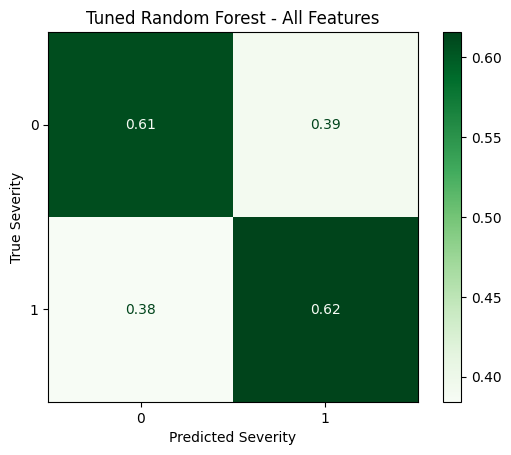

In [4]:
# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_leaf": [1, 5, 10],
}

# Set up a stratified k-fold splitter with k=5
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Wrap the random forest in GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight="balanced", n_jobs=-1
    ),
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

# Fit on train set
grid.fit(X_train, y_train)

# Inspect best params and best score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# Evaluate the best estimator on the hold-out validation set
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_val)

print("\nRandom Forest (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred, display_labels=best_rf.classes_, normalize="true", cmap=plt.cm.Greens
)
plt.title("Tuned Random Forest - All Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
# plt.savefig(f"{os.getenv('CM_ALL_DIR')}/random_forest.png")
plt.show()

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best cross-val F1: 0.4503191501108936

KNN (tuned) Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.66      0.67     28735
           1       0.45      0.46      0.46     17497

    accuracy                           0.59     46232
   macro avg       0.56      0.56      0.56     46232
weighted avg       0.59      0.59      0.59     46232



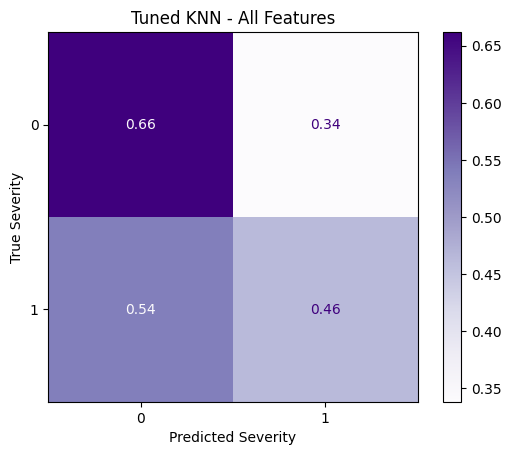

In [5]:
# Set up pipeline consisting of Scaling before KNN
pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

# Parameter grid - knn__ prefix required when using a Pipeline
param_grid = {
    "knn__n_neighbors": [1, 3, 5, 7],
    "knn__weights": ["uniform", "distance"],
}

# Set up a stratified k-fold splitter with k=5
cv = StratifiedKFold(n_splits=5, shuffle=True)

# Wrap the knn pipeline in GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
)

# Fit on the training set
grid.fit(X_train, y_train)

# Inspect best params and best score
print("Best parameters:", grid.best_params_)
print("Best cross-val F1:", grid.best_score_)

# Evaluate the best estimator on the hold-out validation set
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_val)

print("\nKNN (tuned) Classification Report:\n")
print(classification_report(y_val, y_pred, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_val,
    y_pred,
    display_labels=best_knn.named_steps["knn"].classes_,
    normalize="true",
    cmap=plt.cm.Purples,
)
plt.title("Tuned KNN - All Features")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
# plt.savefig(f"{os.getenv('CM_ALL_DIR')}/knn.png")
plt.show()

# Test data results

Final Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.64      0.68     23946
           1       0.50      0.60      0.54     14581

    accuracy                           0.62     38527
   macro avg       0.61      0.62      0.61     38527
weighted avg       0.64      0.62      0.63     38527



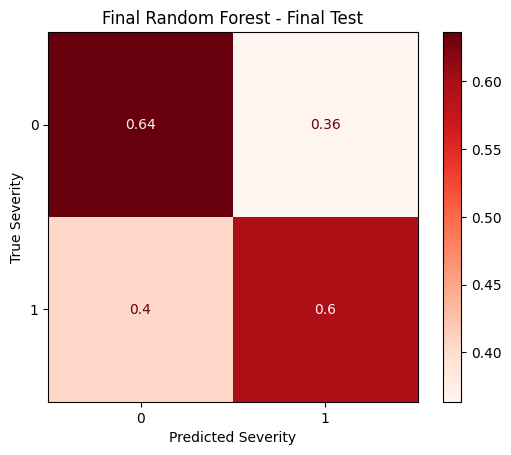

In [6]:
# Define the prep function (same as before)
def prep(df):
    X = (
        df.select_dtypes(include=[np.number])
        .drop(columns=["ACCIDENT_NO", "HIGH_SEVERITY"], errors="ignore")
        .replace([np.inf, -np.inf], np.nan)
        .fillna(0)
    )
    y = df["HIGH_SEVERITY"]
    return X, y

# Load training data
df_full = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")
X_full, y_full = prep(df_full)

# Refit the tuned Random Forest on all training data
best_params = {
    "n_estimators": 200,
    "max_depth": None,
    "min_samples_leaf": 5,
    "class_weight": "balanced",
    "n_jobs": -1,
}

rf_final = RandomForestClassifier(**best_params)
rf_final.fit(X_full, y_full)

# Load and prep the test set
test_df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/test.csv")
X_test, y_test = prep(test_df)

# Predict and evaluate on test set
y_test_pred = rf_final.predict(X_test)
print("Final Test Set Classification Report:\n")
print(classification_report(y_test, y_test_pred, zero_division=0))

# Plot normalized confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred,
    display_labels=rf_final.classes_,
    normalize="true", 
    cmap=plt.cm.Reds,
)

plt.title("Final Random Forest - Final Test")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
#plt.savefig(f"{os.getenv('CM_DIR')}/final_test_results.png")
plt.show()

# Guessing Class Label at Random to Establish a Baseline

              precision    recall  f1-score   support

           0       0.62      0.50      0.55     23946
           1       0.37      0.49      0.43     14581

    accuracy                           0.50     38527
   macro avg       0.50      0.50      0.49     38527
weighted avg       0.53      0.50      0.50     38527



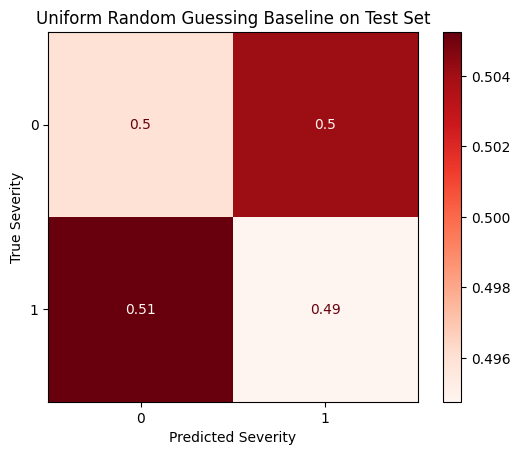

In [7]:
# Uniform random guess baseline
rng = np.random.RandomState(42)

# Draw 0 or 1 with equal probability
y_rand = rng.choice(
    [0, 1],
    size=len(y_test),
    p=[0.5, 0.5],
)

print(classification_report(y_test, y_rand, zero_division=0))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_rand,
    display_labels=rf_final.classes_,
    normalize="true",
    cmap=plt.cm.Reds,
)

plt.title("Uniform Random Guessing Baseline on Test Set")
plt.xlabel("Predicted Severity")
plt.ylabel("True Severity")
df = pd.read_csv(f"{os.getenv('TRAIN_TEST_DATA_DIR')}/train.csv")
#plt.savefig(f"{os.getenv('CM_DIR')}/random_guessing_baseline.png")
plt.show()